# Word2Vec

The code for this lecture is based off the great tutorial example from tensorflow!

Walkthrough:

https://www.tensorflow.org/tutorials/word2vec

Raw Code: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

# Step 0: Imports

In [9]:
import collections
import math
import os
import errno
import random
import zipfile
import re
import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf
from nltk import word_tokenize, sent_tokenize
import string

# Step 1: The data.

In [2]:
data_dir = "word2vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [3]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [16]:
# Use Defaults (this make take awhile!!)
def read_files():
    output = []
    data_file = os.path.abspath("developset/texts/merged-file.txt")
    p = re.compile('[A-Z]{3}[1-9]*-[A-Z]{3}[1-9]*-[0-9]{4}')
    with open(data_file, 'r') as f:
        content = f.readlines()
    file = []
    for c in content:
        if p.match(c) is None:
            file.append(c)

    return str("\n".join(file)).lower()


input_files = read_files()
words = [[w for w in word_tokenize(sent) if w not in string.punctuation] for sent in sent_tokenize(input_files)]
words = [word for sent in words for word in sent]


In [18]:
# Total words
len(words)

94814

In [19]:
# Random slice of words
words[9000:9040]

['recalled',
 'that',
 'in',
 '1980',
 'four',
 'u.s.',
 'nuns',
 'who',
 'were',
 'traveling',
 'from',
 'the',
 'comalapa',
 'airport',
 'to',
 'san',
 'salvador',
 'were',
 'killed',
 'by',
 'salvadoran',
 'national',
 'guardsmen',
 'tegucigalpa',
 '27',
 'jun',
 '89',
 'acan',
 'efe',
 '--',
 'text',
 'an',
 'alleged',
 'sandinist',
 'officer',
 'who',
 'claims',
 'to',
 'have',
 'carried']

In [21]:
for w in words[9000:9040]:
    print(w,end=' ')

recalled that in 1980 four u.s. nuns who were traveling from the comalapa airport to san salvador were killed by salvadoran national guardsmen tegucigalpa 27 jun 89 acan efe -- text an alleged sandinist officer who claims to have carried 

## Build Word Counts

In [22]:
from collections import Counter

In [23]:
mylist = ["one",'one','two']

In [24]:
Counter(mylist)

Counter({'one': 2, 'two': 1})

In [25]:
Counter(mylist).most_common(1)

[('one', 2)]

## Create Word Data and Vocab

In [26]:
def create_counts(vocab_size=90000):

    # Begin adding vocab counts with Counter
    vocab = [] + Counter(words).most_common(vocab_size )
    
    # Turn into a numpy array
    vocab = np.array([word for word, _ in vocab])
    
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab

In [27]:
vocab_size = 90000

In [45]:
# This may take awhile
data,vocabulary = create_counts(vocab_size=vocab_size)


In [46]:
data[0]

32

In [47]:
(words[100],data[100])

('the', 0)

In [48]:
vocabulary.shape

(7714,)

In [51]:
vocabulary[np.random.randint(0,7714)]

'brothers'

## Function for Batches

Direct from the word2vec file from TensorFlow Docs

In [52]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [53]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [54]:
batch

array([28, 28, 28, 28, 28, 28, 28, 28], dtype=int32)

In [55]:
labels

array([[531],
       [ 32],
       [ 32],
       [531],
       [ 32],
       [531],
       [531],
       [ 32]], dtype=int32)

## Constants

In [56]:
# Size of the bath
batch_size = 128

# Dimension of embedding vector
embedding_size = 150

# How many words to consider left and right (the bigger, the longer the training)
skip_window = 1       

# How many times to reuse an input to generate a label
num_skips = 2        

In [57]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

# Random set of words to evaluate similarity on.
valid_size = 16   

# Only pick dev samples in the head of the distribution.
valid_window = 100  
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Number of negative examples to sample.
num_sampled = 64   

# Model Learning Rate
learning_rate = 0.01

# How many words in vocab
vocabulary_size = 50000

## TensorFlow Placeholders and Constants

In [58]:
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Variables

In [59]:
# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [60]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### NCE Loss

In [61]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [62]:
# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

### Optimizer

In [63]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [64]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [65]:
# Add variable initializer.
init = tf.global_variables_initializer()

# Session

In [66]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [68]:
# Usually needs to be quite large to get good results, 
# training takes a longs time!
# num_steps = 200001

num_steps = 1000
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  293.956634521


# Visualizing Results

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

## TSNE

* https://lvdmaaten.github.io/tsne/
* https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

Dimensionality reduction to 2-D vectors (down from 150), this takes awhile.

In [72]:
type(final_embeddings)

numpy.ndarray

In [73]:
final_embeddings.shape

(50000, 150)

In [74]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [83]:
plot_only = 2000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [84]:
labels = [vocabulary[i] for i in range(plot_only)]

In [85]:
low_dim_embs.shape

(2000, 2)

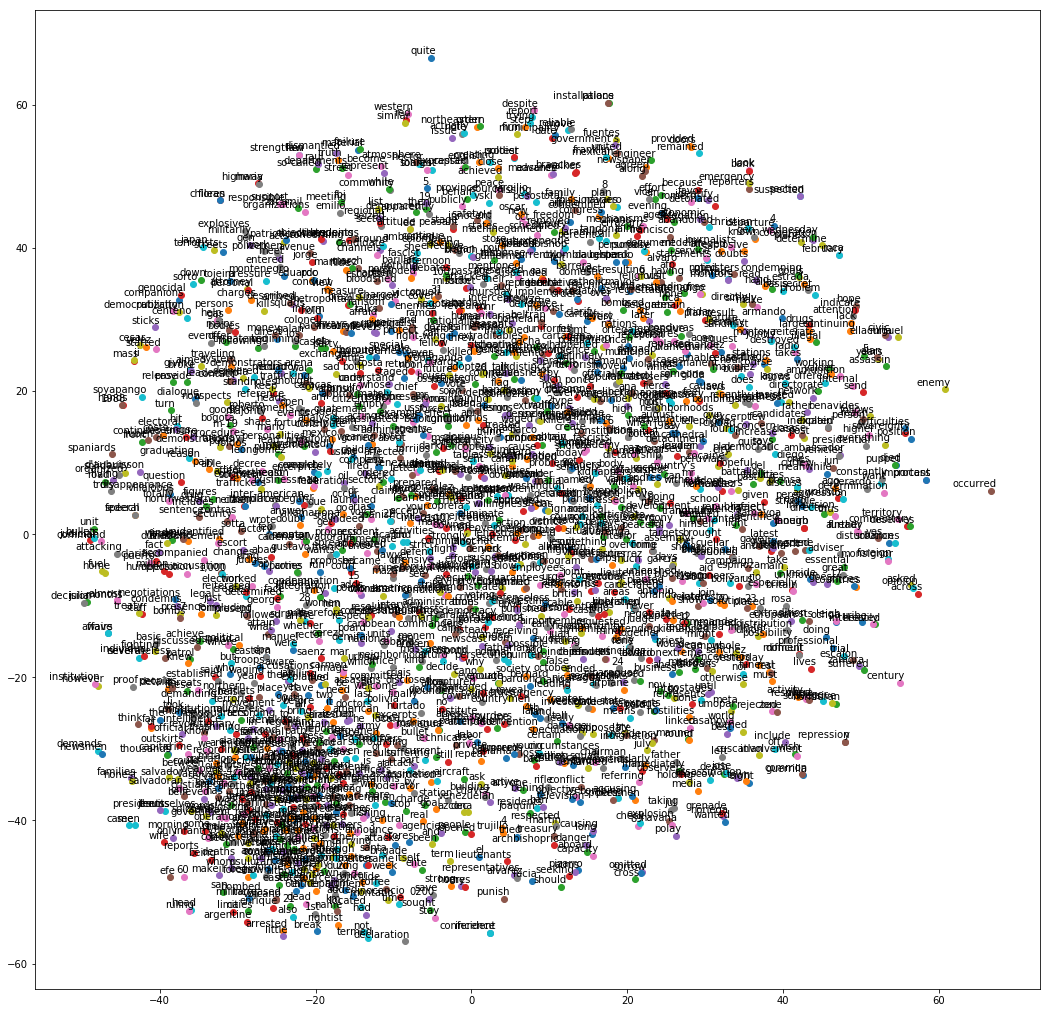

In [86]:
plot_with_labels(low_dim_embs, labels)

(-10, 10)

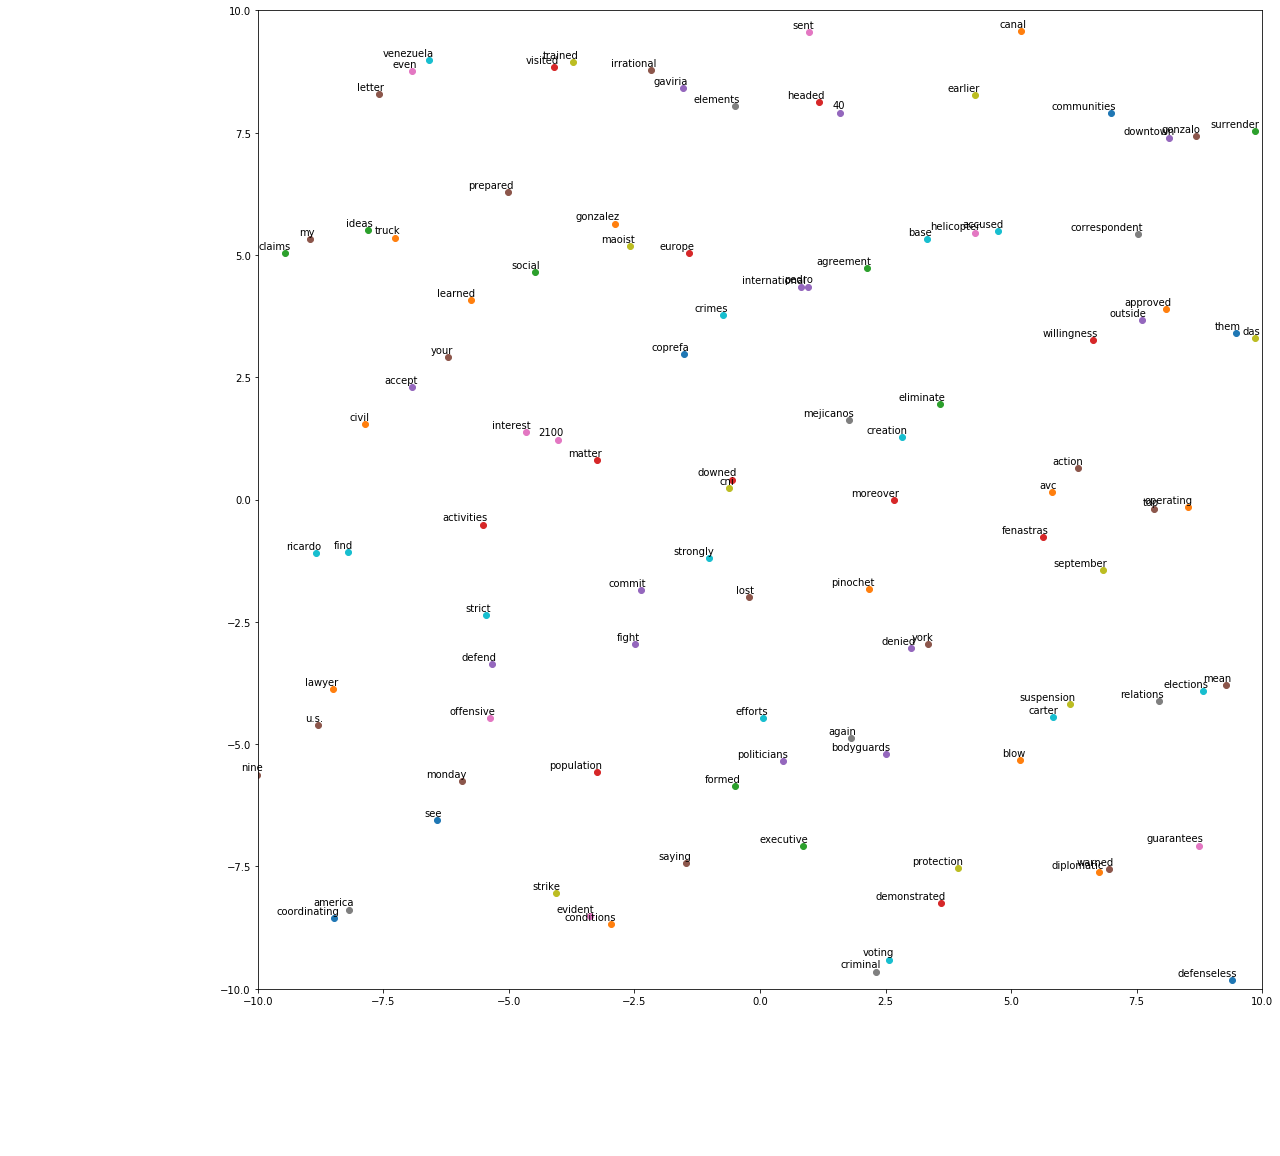

In [87]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)

## Also check out gensim!

https://radimrehurek.com/gensim/tutorial.html

https://stackoverflow.com/questions/40074412/word2vec-get-nearest-words

In [90]:
np.save('trained_embeddings_1000_steps',final_embeddings)

# Great Job!